In [7]:
import albumentations as A
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import gc

def data_transform(df, target_size: int):
    """
    Transform each image in the DataFrame to a specified size.

    Parameters:
    - df: DataFrame containing the image data, each row is a flattened image.
    - target_size: int, the width and height to resize each image to.

    Returns:
    - array_list: list of transformed images as flattened arrays.
    """
    transform = A.Compose([
        A.Resize(width=target_size, height=target_size),
    ])
    array_list = []
    
    for i in range(df.shape[0]):
        # Reshape each row to 28x28, apply transform, and flatten to target_size*target_size
        img = df.iloc[i, :].values.reshape(28, 28)
        transformed = transform(image=img.astype(np.uint8))
        transformed_image = transformed["image"].astype(None)
        data_img = transformed_image.reshape(target_size * target_size)
        array_list.append(data_img)
        
        # Print progress every 1000 iterations
        if i > 0 and i % 1000 == 0:
            print(f"Processed {i} images out of {df.shape[0]}")    
    # Perform garbage collection after processing
    gc.collect()
    return array_list


def data_preprocess(array_list):
    """
    加载 CSV 文件中的图像数据，并将它们转换为 128x128 的格式
    """
    res_ttf = np.asarray(array_list)
    return torch.tensor(res_ttf).reshape(-1, 1, 224, 224).float()


# predict_df = pd.read_csv('./test.csv')
# predict_array_list = data_transform(predict_df, 224)

# import pickle
# Save the transformed data to disk
# with open('predict_data.pkl', 'wb') as f:
#     pickle.dump(predict_array_list, f)

In [8]:
import torch.nn as nn

class VGGNet(nn.Module):
    def __init__(self, num_classes=10, init_weights=True):
        super(VGGNet, self).__init__()

        self.features = nn.Sequential(
            # Block 1: 2Conv + 1MaxPool
            self.vgg_block(num_convs=2, in_channels=1, out_channels=64), # 1*224*224 -> 64*112*112
            # Block 2: 2Conv + 1MaxPool
            self.vgg_block(num_convs=2, in_channels=64, out_channels=128), # 64*112*112 -> 128*56*56
            # Block 3: 3Conv + 1MaxPool
            self.vgg_block(num_convs=3, in_channels=128, out_channels=256), # 128*56*56 -> 256*28*28
            # Block 4: 3Conv + 1MaxPool
            self.vgg_block(num_convs=3, in_channels=256, out_channels=512), # 256*28*28 -> 512*14*14
            # Block 5: 3Conv + 1MaxPool
            self.vgg_block(num_convs=3, in_channels=512, out_channels=512), # 512*14*14 -> 512*7*7
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # 512*7*7 -> 4096
            nn.ReLU(inplace=True), 
            nn.Linear(4096, num_classes),   # 4096 -> 10
        )

        if init_weights:
            self._init_weights() # initialize weights

    def vgg_block(self, num_convs, in_channels, out_channels):
        layers = []
        for _ in range(num_convs): # (1 conv + 1 relu) * num_convs
            layers.append(nn.Conv2d(in_channels, out_channels,
                                    kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch Normalization
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2)) # 1 MaxPool
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)  # 5 VGG blocks
        x = torch.flatten(x, start_dim=1) # flatten
        x = self.classifier(x)  # 3 FC layers
        return x

    def _init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)
            elif isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(layer.bias, 0)


In [10]:
import albumentations as A
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm  # Fixed to directly use tqdm
import pickle


def test_single_image(img_tensor, model):
    """
    Predict the label of a single image.
    """
    model.eval()
    with torch.no_grad():
        prediction = model(img_tensor)
    return prediction.argmax(dim=1).item()  # Specify dimension for argmax


def generate_submission(predict_data_path='predict_data.pkl', model_path='./VGG16_net.pkl', output_path="submission.csv"):
    """
    Generate a submission file for the Kaggle competition.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    with open(predict_data_path, 'rb') as f:
        predict_array_list = pickle.load(f)

    predict_images_tensor = data_preprocess(predict_array_list)  # Ensure this function exists
    model = torch.load(model_path, map_location=device)
    model.eval()
    model.to(device)

    predictions = []

    print("Running predictions...")
    # Using tqdm to show the progress
    for img in tqdm(predict_images_tensor, desc="Processing Images"):
        img = img.unsqueeze(0).to(device)  # Adding batch dimension and moving to device
        result = test_single_image(img, model)
        predictions.append(result)

    submission_df = pd.DataFrame({
        "ImageId": np.arange(1, len(predictions) + 1),
        "Label": predictions
    })

    submission_df.to_csv(output_path, index=False)
    print(f"Submission file saved as '{output_path}'")


# Call function to generate submission file
generate_submission(predict_data_path='predict_data.pkl', model_path='./VGG-16.pkl', output_path="VGG_submission.csv")

# Optionally run with a different model
# generate_submission(predict_data_path='predict_data.pkl', model_path='./Res18_net.pkl', output_path="Res_submission.csv")


/var/folders/l_/t15z68h5545gnmg_nk6tn8r00000gn/T/ipykernel_65983/751601972.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=d

Running predictions...


Processing Images: 100%|██████████| 28000/28000 [1:23:21<00:00,  5.60it/s]


Submission file saved as 'VGG_submission.csv'


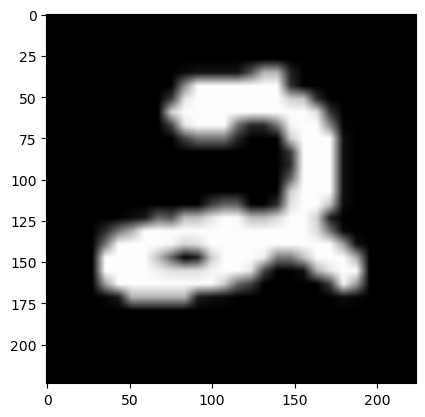

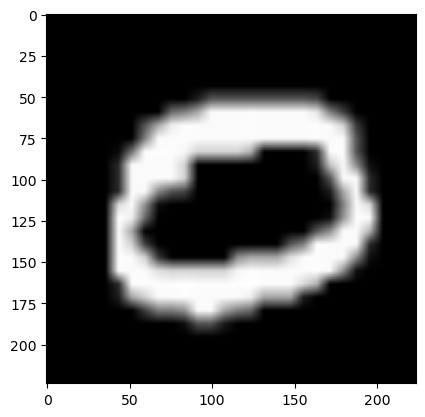

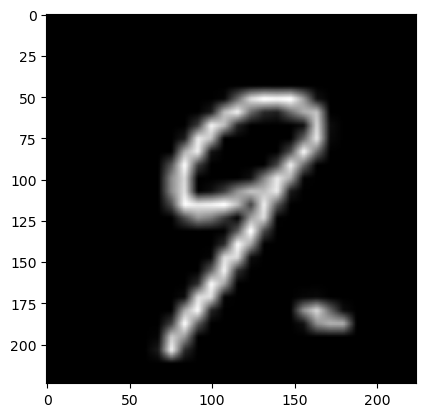

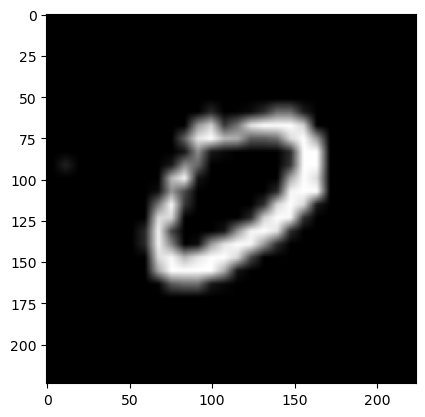

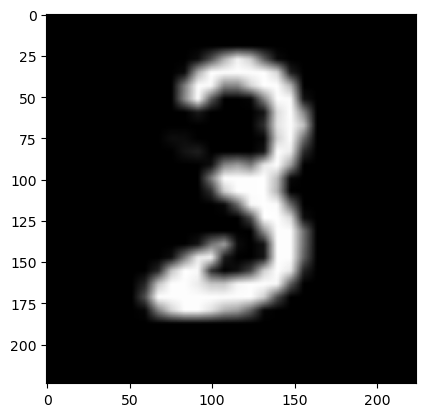

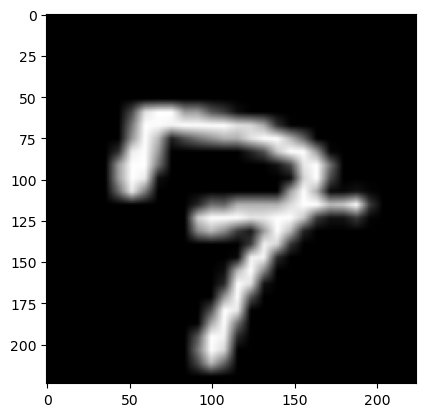

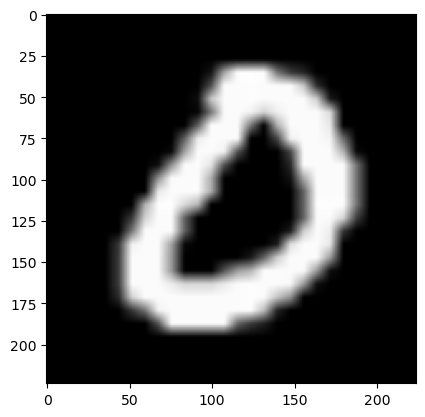

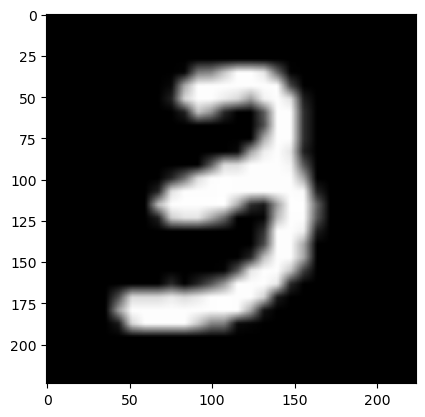

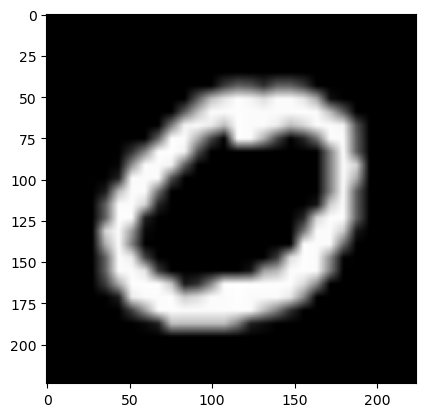

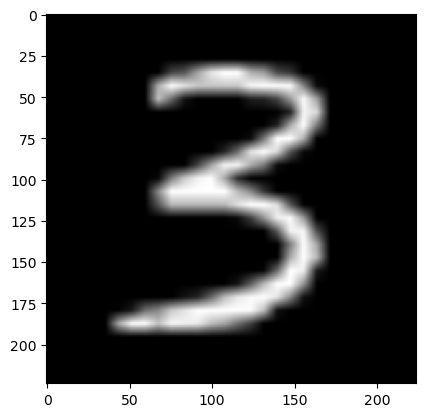

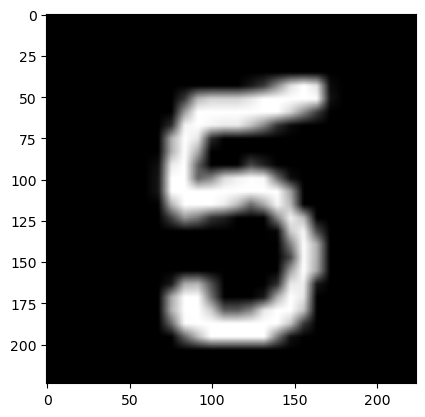

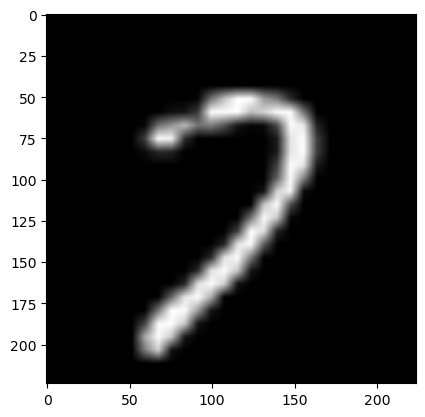

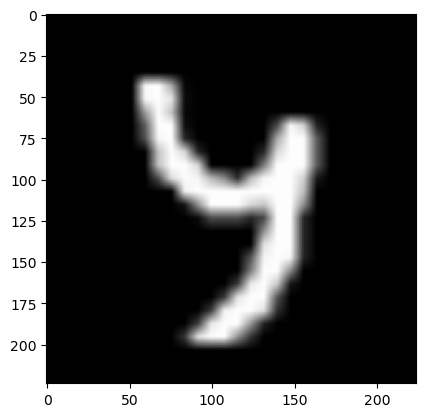

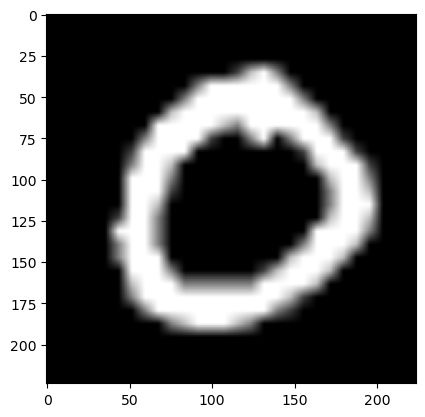

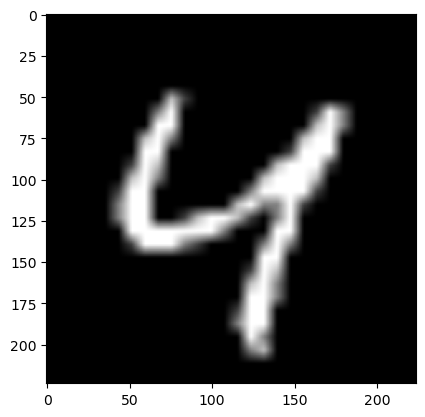

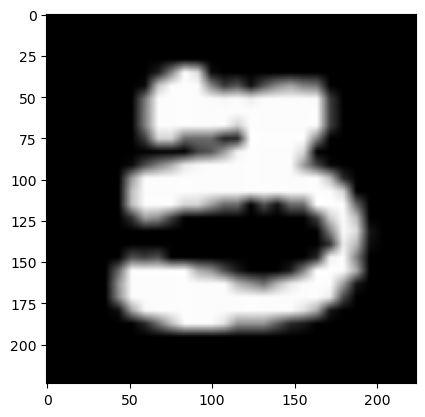

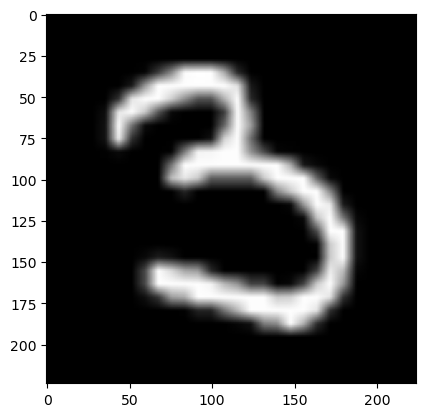

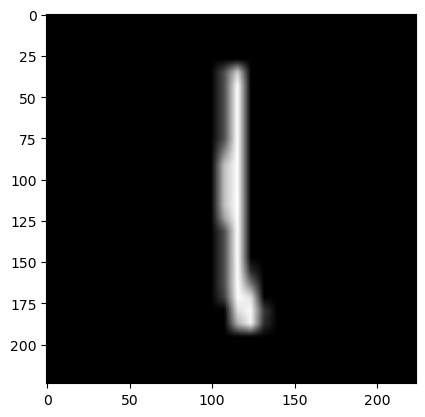

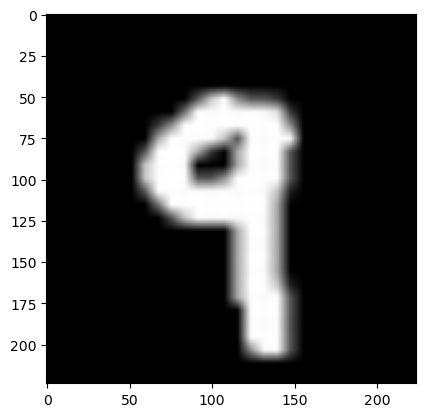

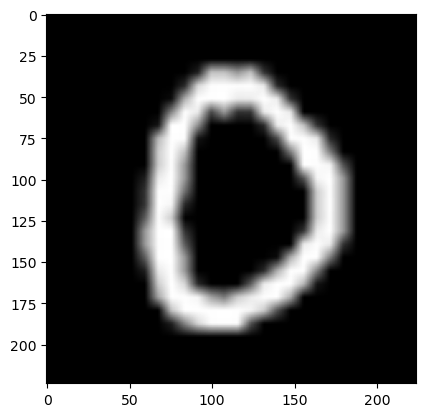

In [12]:
# test your model
from matplotlib import pyplot as plt

with open('predict_data.pkl', 'rb') as f:
    predict_array_list = pickle.load(f)

def show_pic(ttf,n):
    data = ttf[n]
    data = data.reshape(1,1,224,224)
    data = torch.tensor(data).float()
    plt.imshow(data.reshape(224,224),cmap='gray')

for i in range(20):
    show_pic(predict_array_list,i)
    plt.show()

